## Imports

In [1]:
%env CUDA_VISIBLE_DEVICES=1
%matplotlib inline

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow as tf
import data.data_selector as ds
import utils.data_processing as dp
import utils.plot_functions as pf
import analysis.analysis_picker as ap

In [3]:
analysis_params = {
  #"model_type": "ica",
  #"model_type": "lca",
  #"model_type": "sparse_autoencoder",
  "model_type": "gdn_autoencoder",
  #"model_name": "ica",
  #"model_name": "lca_256_l0_0.5",
  #"model_name": "lca_vh_ft_1c",
  #"model_name": "lca_vh_ft_1c_ht",
  #"model_name": "lca_vh_ft_white",
  #"model_name": "lca_vh_ft_64d_96n",
  #"model_name": "sparse_autoencoder",
  "model_name": "gdn_autoencoder",
  #"version": "0.0",
  "version": "1.0",
  #"version": "2.0",
  #"version": "3.0",
  #"save_info": "full_imgs"}
  "save_info": "analysis"}

# Computed params
#analysis_params["model_dir"] = (os.path.expanduser("~")+"/Work/Projects/nowht_v3/"+analysis_params["model_name"]+"_v"+analysis_params["version"])
analysis_params["model_dir"] = (os.path.expanduser("~")+"/Work/Projects/"+analysis_params["model_name"])

In [4]:
analyzer = ap.get_analyzer(analysis_params)
analyzer.model.setup(analyzer.model_params, analyzer.model_schedule)
analyzer.load_analysis(save_info=analysis_params["save_info"])

ot_bf_indices = analyzer.ot_grating_responses["neuron_indices"]
ot_contrasts = analyzer.ot_grating_responses["contrasts"]
ot_phases = analyzer.ot_grating_responses["phases"]
ot_orientations = analyzer.ot_grating_responses["orientations"]
ot_best_phases = analyzer.ot_grating_responses["best_phases"]
ot_mean_activations = analyzer.ot_grating_responses["mean_responses"]

co_bf_indices = analyzer.co_grating_responses["neuron_indices"]
co_contrasts = analyzer.co_grating_responses["contrasts"]
co_phases = analyzer.co_grating_responses["phases"]
co_base_orientations = analyzer.co_grating_responses["base_orientations"]
co_mask_orientations = analyzer.co_grating_responses["mask_orientations"]
co_base_mean_responses = analyzer.co_grating_responses["base_mean_responses"]
co_test_mean_responses = analyzer.co_grating_responses["test_mean_responses"]

In [48]:
import data.data_selector as ds
analyzer.model_params["data_type"] = analysis_params["data_type"]
data = ds.get_data(analyzer.model_params)
data = analyzer.model.preprocess_dataset(data)
data = analyzer.model.reshape_dataset(data, analyzer.model_params)
analyzer.model_params["data_shape"] = [                                                       
  data["train"].num_rows*data["train"].num_cols*data["train"].num_channels]     

In [49]:
print(data["train"].images.shape)

(1000000, 81)


In [53]:
var_names = ["weights/gdn_w:0"]
evals = analyzer.evaluate_model(data["train"].images, var_names)

INFO:tensorflow:Restoring parameters from /home/dpaiton/Work/Projects/gdn_autoencoder/checkpoints/gdn_autoencoder_v1.0_weights-100000


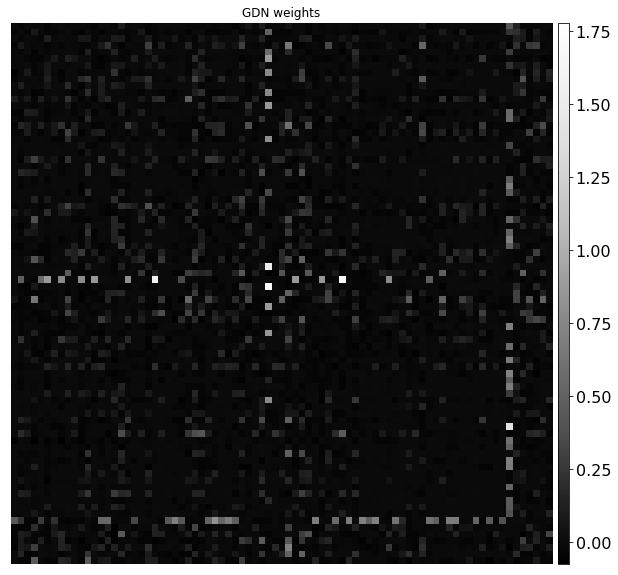

In [69]:
gdn_weights = evals['weights/gdn_w:0']
fig, ax = plt.subplots(1, 1, figsize=(10,10))
im = ax.imshow(gdn_weights, vmin=np.min(gdn_weights), vmax=np.max(gdn_weights), cmap="Greys_r")
ax.set_title("GDN weights")
pf.clear_axis(ax)
pf.add_colorbar_to_im(im, aspect=50)
plt.show()

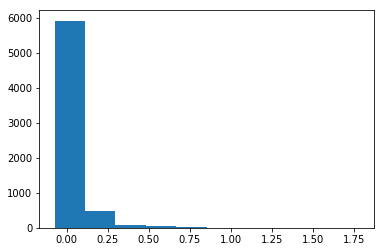

In [72]:
plt.hist(gdn_weights.ravel())
plt.show()

In [78]:
max_indices = np.unravel_index(np.argmax(gdn_weights), dims=gdn_weights.shape)
print(max_indices)
print(gdn_weights[max_indices])

(39, 38)
1.7793226


In [5]:
num_pixels = analyzer.model_params["patch_edge_size"]**2
neuron_angles = np.zeros((analyzer.bf_stats["num_outputs"], analyzer.bf_stats["num_outputs"]))
for neuron1 in range(analyzer.bf_stats["num_outputs"]):
  #for neuron2 in range(0,neuron1):
  #  neuron_angles[neuron1, neuron2] = None
  #for neuron2 in range(neuron1, analyzer.bf_stats["num_outputs"]):
  for neuron2 in range(analyzer.bf_stats["num_outputs"]):
    bf1 = analyzer.bf_stats["basis_functions"][neuron1].reshape((num_pixels,1))
    bf2 = analyzer.bf_stats["basis_functions"][neuron2].reshape((num_pixels,1))
    inner_products = np.dot((bf1/np.linalg.norm(bf1)).T, bf2/np.linalg.norm(bf2))
    inner_products[inner_products>1.0] = 1.0
    inner_products[inner_products<-1.0] = -1.0
    angle = np.arccos(inner_products)
    neuron_angles[neuron1, neuron2] = angle

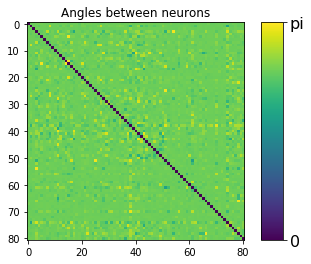

In [6]:
cmap = plt.get_cmap('viridis')
vmin = 0
vmax = np.pi
cNorm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=cmap)
scalarMap._A = []
plt.show()
fig, ax = plt.subplots(1)
im = ax.imshow(neuron_angles)
ax.set_title("Angles between neurons")
cbar = fig.colorbar(scalarMap, ax=ax, ticks=[vmin, vmax], aspect=10)
cbar.ax.set_yticklabels(["0","pi"])
cbar.ax.tick_params(labelsize=16)
plt.show()

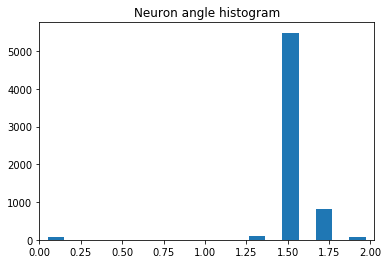

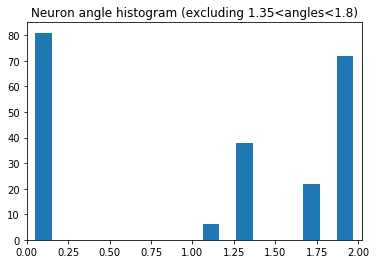

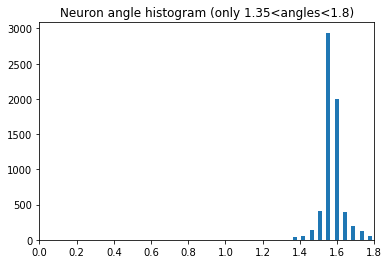

In [8]:
angles = neuron_angles[np.isfinite(neuron_angles)].flatten()
fig, ax = plt.subplots(1)
ax.hist(angles, rwidth=0.5)
ax.set_xlim([0, np.max(angles)])
ax.set_title("Neuron angle histogram")
plt.show()

sm_angles = angles[angles<1.35]
bg_angles = angles[angles>1.8]
windowed_angles = np.concatenate([sm_angles, bg_angles]).flatten()
fig, ax = plt.subplots(1)
ax.hist(windowed_angles, rwidth=0.5)
ax.set_xlim([0, np.max(angles)])
ax.set_title("Neuron angle histogram (excluding 1.35<angles<1.8)")
plt.show()

angles = angles[angles>1.35]
angles = angles[angles<1.8]
fig, ax = plt.subplots(1)
ax.hist(angles, rwidth=0.5)
ax.set_xlim([0, np.max(angles)])
ax.set_title("Neuron angle histogram (only 1.35<angles<1.8)")
plt.show()

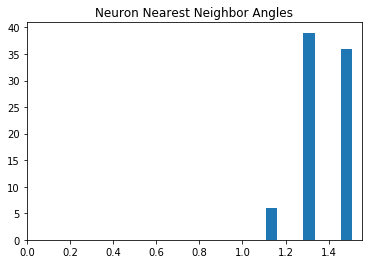

In [88]:
nn_angles = np.zeros(analyzer.bf_stats["num_outputs"])
for neuron_id in range(analyzer.bf_stats["num_outputs"]): 
  neighbors = neuron_angles[neuron_id,:]
  nn_angles[neuron_id] = np.min(np.delete(neighbors, neuron_id))
fig, ax = plt.subplots(1)
ax.hist(nn_angles.flatten(), rwidth=0.3, bins=np.linspace(0,np.pi/2,10))
ax.set_xlim([0, np.max(nn_angles)])
ax.set_title("Neuron Nearest Neighbor Angles")
plt.show()

num vectors =  3846
min angle =  1.5500918626785278  rad
min angle is at index  1431
vector angle	=  1.5612462759017944  rad
		=  89.45282238969011  deg
bf1 norm =  23.706419
bf2 norm =  3.0449107


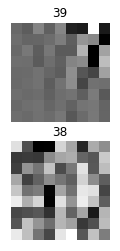

In [79]:
#min_angle = 0.01
#max_angle = 1.3
min_angle = 1.55
max_angle = 1.59

vectors = np.argwhere(np.logical_and(neuron_angles<max_angle, neuron_angles>min_angle))
print("num vectors = ", vectors.shape[0])

if vectors.shape[0] > 0:
  print("min angle = ", np.min(neuron_angles[vectors[:,0], vectors[:,1]]), " rad")
  print("min angle is at index ", np.argmin(neuron_angles[vectors[:,0], vectors[:,1]]))

  vector_id = 1404
  bf_id1 = max_indices[0]#vectors[vector_id, 0]
  bf_id2 = max_indices[1]#vectors[vector_id, 1]

  fig, ax = plt.subplots(2)
  ax[0] = pf.clear_axis(ax[0])
  ax[0].imshow(analyzer.bf_stats["basis_functions"][bf_id1], cmap="Greys_r")
  ax[0].set_title(str(bf_id1))
  ax[1] = pf.clear_axis(ax[1])
  ax[1].imshow(analyzer.bf_stats["basis_functions"][bf_id2], cmap="Greys_r")
  ax[1].set_title(str(bf_id2))

  print("vector angle\t= ", neuron_angles[bf_id1, bf_id2], " rad\n\t\t= ", neuron_angles[bf_id1, bf_id2]*(180/np.pi), " deg")
  bf1 = analyzer.bf_stats["basis_functions"][bf_id1].reshape((num_pixels))
  bf2 = analyzer.bf_stats["basis_functions"][bf_id2].reshape((num_pixels))
  bf1_norm = np.linalg.norm(bf1)
  bf2_norm = np.linalg.norm(bf2)
  print("bf1 norm = ", bf1_norm)
  print("bf2 norm = ", bf2_norm)
  bf1 /= bf1_norm
  bf2 /= bf2_norm

In [80]:
# need to find two orthogonal vectors that have the same span as these two bfs
v = bf2 - np.dot(bf2[:,None].T, bf1[:,None]) * bf1
v = np.squeeze((v / np.linalg.norm(v)).T)
proj_matrix = np.stack([bf1,v], axis=0)
proj_neuron1 = np.dot(proj_matrix, bf1)
proj_neuron2 = np.dot(proj_matrix, bf2)
print(proj_neuron1)
print(proj_neuron2)
print(np.linalg.norm(proj_neuron2))

[9.9999994e-01 4.6566129e-10]
[0.00954986 0.9999544 ]
1.0


In [81]:
num_imgs = 10000
y_pts = np.linspace(-2.0, 2.0, int(np.sqrt(num_imgs)))
x_pts = np.linspace(-2.0, 2.0, int(np.sqrt(num_imgs)))
X,Y = np.meshgrid(x_pts, y_pts)
proj_datapoints = np.stack([Y.reshape(num_imgs), X.reshape(num_imgs)], axis=1)
datapoints = np.stack([np.dot(proj_matrix.T, proj_datapoints[data_id,:]) for data_id in range(num_imgs)]) #inject

In [82]:
#plt.imshow(datapoints[-12,:].reshape(16,16), cmap="Greys_r")
#plt.show()

In [83]:
#var_names = ["inference/activity:0"]
#activations = analyzer.evaluate_model(datapoints, var_names)["inference/activity:0"]

var_names = ["inference/gdn_output:0"]
activations = analyzer.evaluate_model(datapoints, var_names)["inference/gdn_output:0"]

#var_names = ["inference/coefficients:0"]
#activations = analyzer.evaluate_model(datapoints, var_names)["inference/coefficients:0"]

activity_max = np.max(np.abs(activations))
norm_activity = activations / (activity_max+0.0001)

INFO:tensorflow:Restoring parameters from /home/dpaiton/Work/Projects/gdn_autoencoder/checkpoints/gdn_autoencoder_v1.0_weights-100000


In [84]:
#datapoints = np.squeeze(np.stack([bf1, bf2]))
#activations = analyzer.evaluate_model(datapoints, var_names)["inference/activity:0"]
#print("num nonzero for bf1: ", np.count_nonzero(activations[0,:]))
#print("num nonzero for bf2: ", np.count_nonzero(activations[1,:]))
#fig, ax = plt.subplots(1)
#ax.hist(activations[1,:], rwidth=0.5)
#ax.set_title("Activity histogram for a basis function as input")
#plt.show()

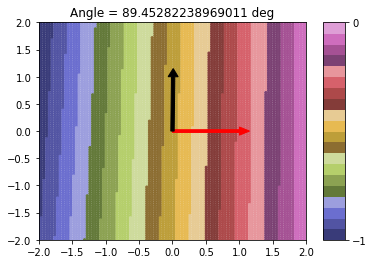

In [85]:
neuron_idx = bf_id1
fig, ax = plt.subplots(1)
cmap = plt.get_cmap('tab20b')
#cmap = plt.get_cmap('viridis')
#cmap = plt.get_cmap('jet')
vmin = np.floor(np.min(norm_activity))#0.0
vmax = np.ceil(np.max(norm_activity))#1.0
cNorm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=cmap)
rank_indices = np.argsort(norm_activity[:,neuron_idx])
colors = [scalarMap.to_rgba(norm_activity[data_id, neuron_idx]) for data_id in rank_indices]
ax.scatter(proj_datapoints[:,0][rank_indices], proj_datapoints[:,1][rank_indices], c=colors, s=5.0)
#ax.contour(Y, X, norm_activity[:,neuron_idx].reshape(100,100), linewidths=3)
ax.arrow(0, 0, proj_neuron1[0].item(), proj_neuron1[1].item(), width=0.05, head_width=0.15, head_length=0.15, fc='r', ec='r')
ax.arrow(0, 0, proj_neuron2[0].item(), proj_neuron2[1].item(), width=0.05, head_width=0.15, head_length=0.15, fc='k', ec='k')
ax.set_title("Angle = "+str(neuron_angles[bf_id1, bf_id2]*(180/np.pi))+" deg")
ax.set_ylim([-2, 2.0])
ax.set_xlim([-2, 2.0])
scalarMap._A = []
cbar = fig.colorbar(scalarMap, ax=ax, ticks=[vmin, vmax], aspect=10)
plt.show()

In [86]:
num_imgs = 10**2
line_list = [None,]*(analyzer.bf_stats["num_outputs"]-1)
bf_list = [idx for idx in range(analyzer.bf_stats["num_outputs"]) if idx != neuron_idx]
bf1 = analyzer.bf_stats["basis_functions"][neuron_idx].reshape((num_pixels))
y_pts = [1.5,]*num_imgs#np.linspace(-2.0, 2.0, int(np.sqrt(num_imgs)))
x_pts = np.linspace(-2.0, 2.0, num_imgs)
pop_proj_datapoints = np.stack([y_pts, x_pts], axis=1)
pop_datapoints = []
for line_id in range(analyzer.bf_stats["num_outputs"]-1):
  bf2 = analyzer.bf_stats["basis_functions"][bf_list[line_id]].reshape((num_pixels))
  v = bf2 - np.dot(bf2[:,None].T, bf1[:,None]) * bf1
  v = np.squeeze((v / np.linalg.norm(v)).T)
  proj_matrix = np.stack([bf1,v], axis=0)
  pop_datapoints.append(np.stack([np.dot(proj_matrix.T, pop_proj_datapoints[data_id,:]) for data_id in range(num_imgs)]))
pop_datapoints = np.concatenate(pop_datapoints, axis=0)
#var_names = ["inference/activity:0"]
#var_names = ["inference/coefficients:0"]
var_names = ["inference/gdn_output:0"]
pop_activations = analyzer.evaluate_model(pop_datapoints, var_names)[var_names[0]]
pop_activations = pop_activations.reshape([analyzer.bf_stats["num_outputs"]-1, num_imgs, analyzer.bf_stats["num_outputs"]])

INFO:tensorflow:Restoring parameters from /home/dpaiton/Work/Projects/gdn_autoencoder/checkpoints/gdn_autoencoder_v1.0_weights-100000


0.17251565


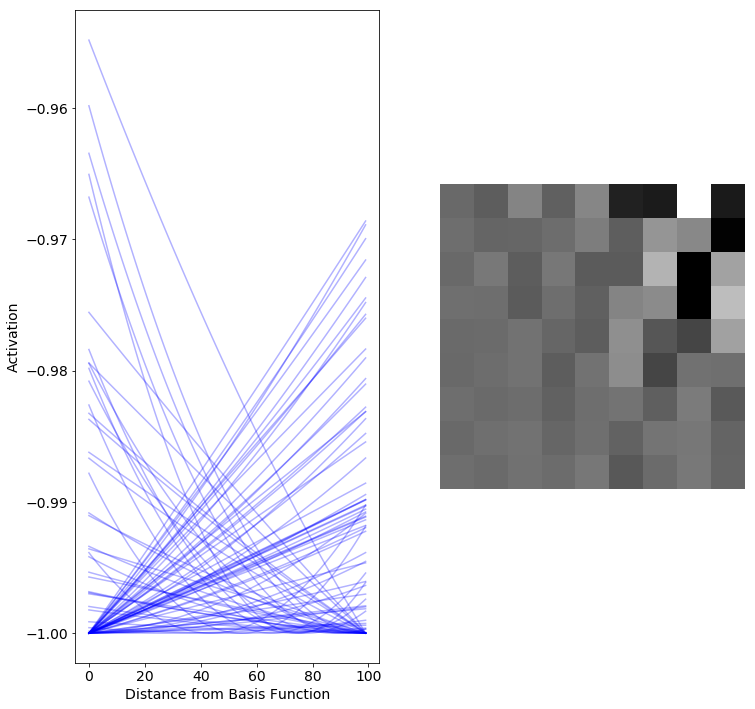

In [87]:
print(np.max(np.abs(pop_activations[:,:,neuron_idx])))
line_list = [pop_activations[idx, :, neuron_idx]/np.max(np.abs(pop_activations[idx, :, neuron_idx]))
  for idx in range(analyzer.bf_stats["num_outputs"]-1)]
fig, ax = plt.subplots(1,2, figsize=(12,12))
ax[0].plot(np.asarray(line_list).T, color='b', alpha=0.3)
#ax[0].set_ylim([0.0,1.1])
ax[0].set_ylabel("Activation", fontsize=14)
ax[0].set_xlabel("Distance from Basis Function", fontsize=14)
#ax[0].set_aspect(100)
ax[0].tick_params(labelsize=14)
ax[1] = pf.clear_axis(ax[1])
ax[1].imshow(analyzer.bf_stats["basis_functions"][neuron_idx], cmap="Greys_r")
plt.show()

Plotting 800 datapoints with responeses within eps = 0.05 of target = 0.2


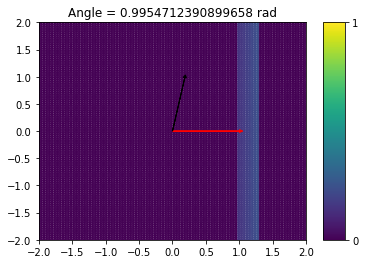

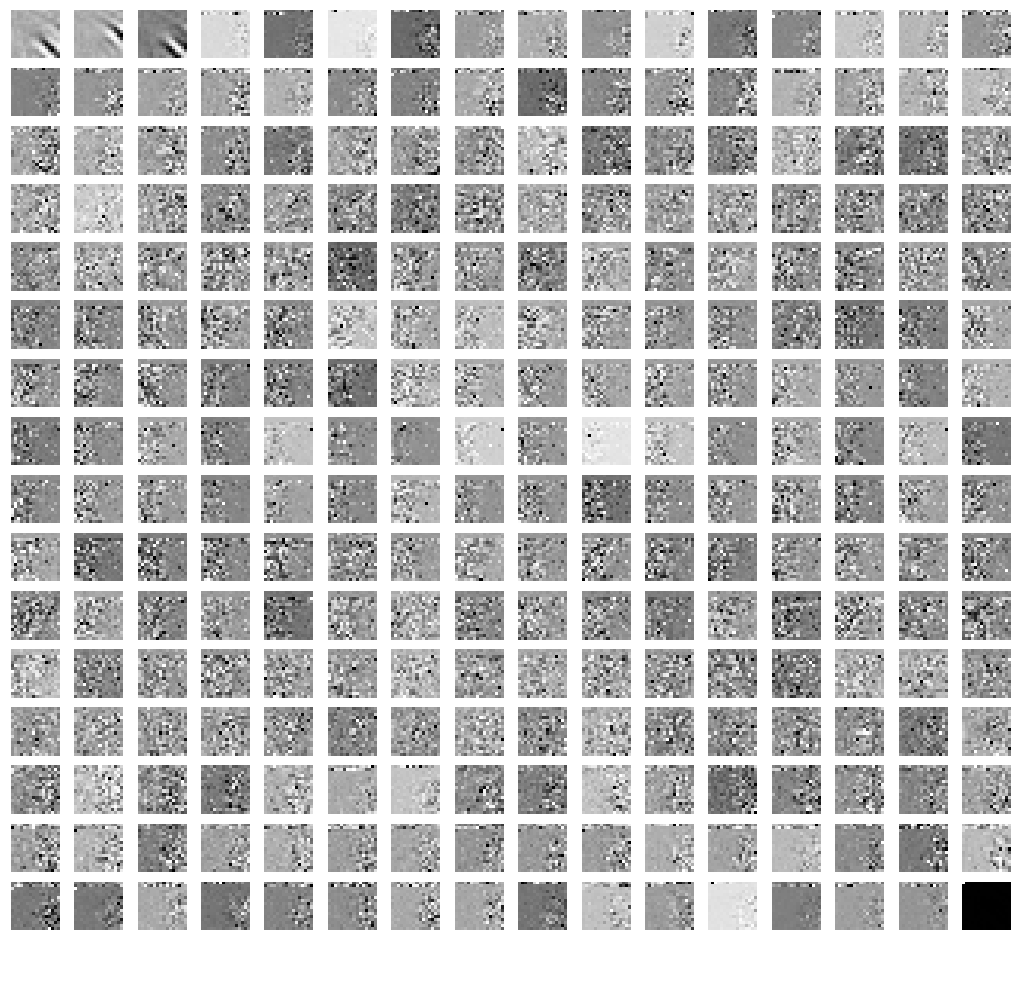

/home/dpaiton/tensorflow/lib/python3.4/site-packages/matplotlib/axes/_base.py:3291: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


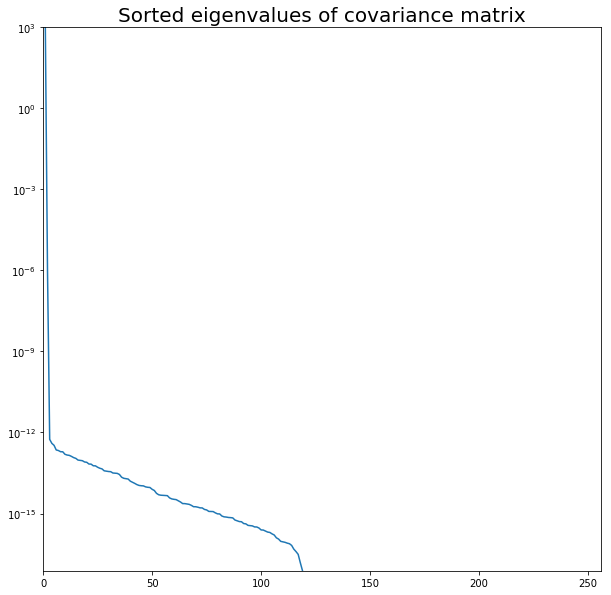

In [166]:
# Find datapoints along one contour
target_activity = 0.2
eps = 0.05
neuron_activity = norm_activity[:, neuron_idx]
iso_activities = neuron_activity[neuron_activity>target_activity-eps]
iso_activities = iso_activities[iso_activities<target_activity+eps]
iso_indices = np.arange(neuron_activity.shape[0])[np.in1d(neuron_activity, iso_activities)]
print("Plotting",len(iso_indices), "datapoints with responeses within eps =",eps,"of target =",target_activity)

fig, ax = plt.subplots(1)
#cmap = plt.get_cmap('tab20b')
cmap = plt.get_cmap('viridis')
#cmap = plt.get_cmap('jet')
vmin = 0.0
vmax = 1.0
cNorm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=cmap)
rank_indices = np.argsort(neuron_activity)
colors = [None]*len(rank_indices)
for data_id in rank_indices:
  if data_id in iso_indices:
    colors[data_id] = scalarMap.to_rgba(neuron_activity[data_id])
  else:
    colors[data_id] = scalarMap.to_rgba(0.0)
#colors = [scalarMap.to_rgba(neuron_activity[data_id]) for data_id in rank_indices if data_id in iso_indices]
ax.scatter(proj_datapoints[:,0][rank_indices], proj_datapoints[:,1][rank_indices], c=colors, s=5.0)
ax.arrow(0, 0, proj_neuron1[0].item(), proj_neuron1[1].item(), head_width=0.05, head_length=0.05, fc='r', ec='r')
ax.arrow(0, 0, proj_neuron2[0].item(), proj_neuron2[1].item(), head_width=0.05, head_length=0.05, fc='k', ec='k')
ax.set_title("Angle = "+str(neuron_angles[bf_id1, bf_id2])+" rad")
ax.set_ylim([-2, 2.0])
ax.set_xlim([-2, 2.0])
scalarMap._A = []
cbar = fig.colorbar(scalarMap, ax=ax, ticks=[0, 1], aspect=10)
plt.show()

target_datapoints = datapoints[iso_indices,:] - np.mean(datapoints[iso_indices,:])
iso_cov = np.dot(target_datapoints.T, target_datapoints)
evals, evecs = np.linalg.eigh(iso_cov) 

fig1 = pf.plot_weights(evecs.T.reshape(256, 16, 16)[::-1,...])

fig2 = pf.plot_eigenvalues(evals[::-1])

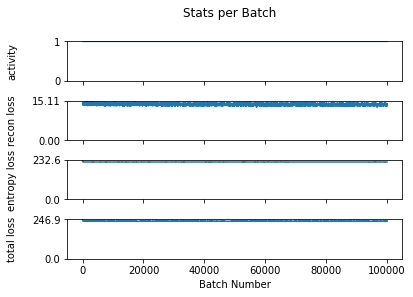

In [43]:
#keys=["a_fraction_active", "recon_loss", "sparse_loss", "total_loss"]
#labels=["activity", "recon loss", "sparse loss", "total loss"]
keys=["a_fraction_active", "recon_loss", "entropy_loss", "total_loss"]
labels=["activity", "recon loss", "entropy loss", "total loss"]
stats_fig = pf.plot_stats(analyzer.run_stats, keys=keys, labels=labels)
stats_fig.savefig(analyzer.analysis_out_dir+analysis_params["model_name"]+"_train_stats.png")

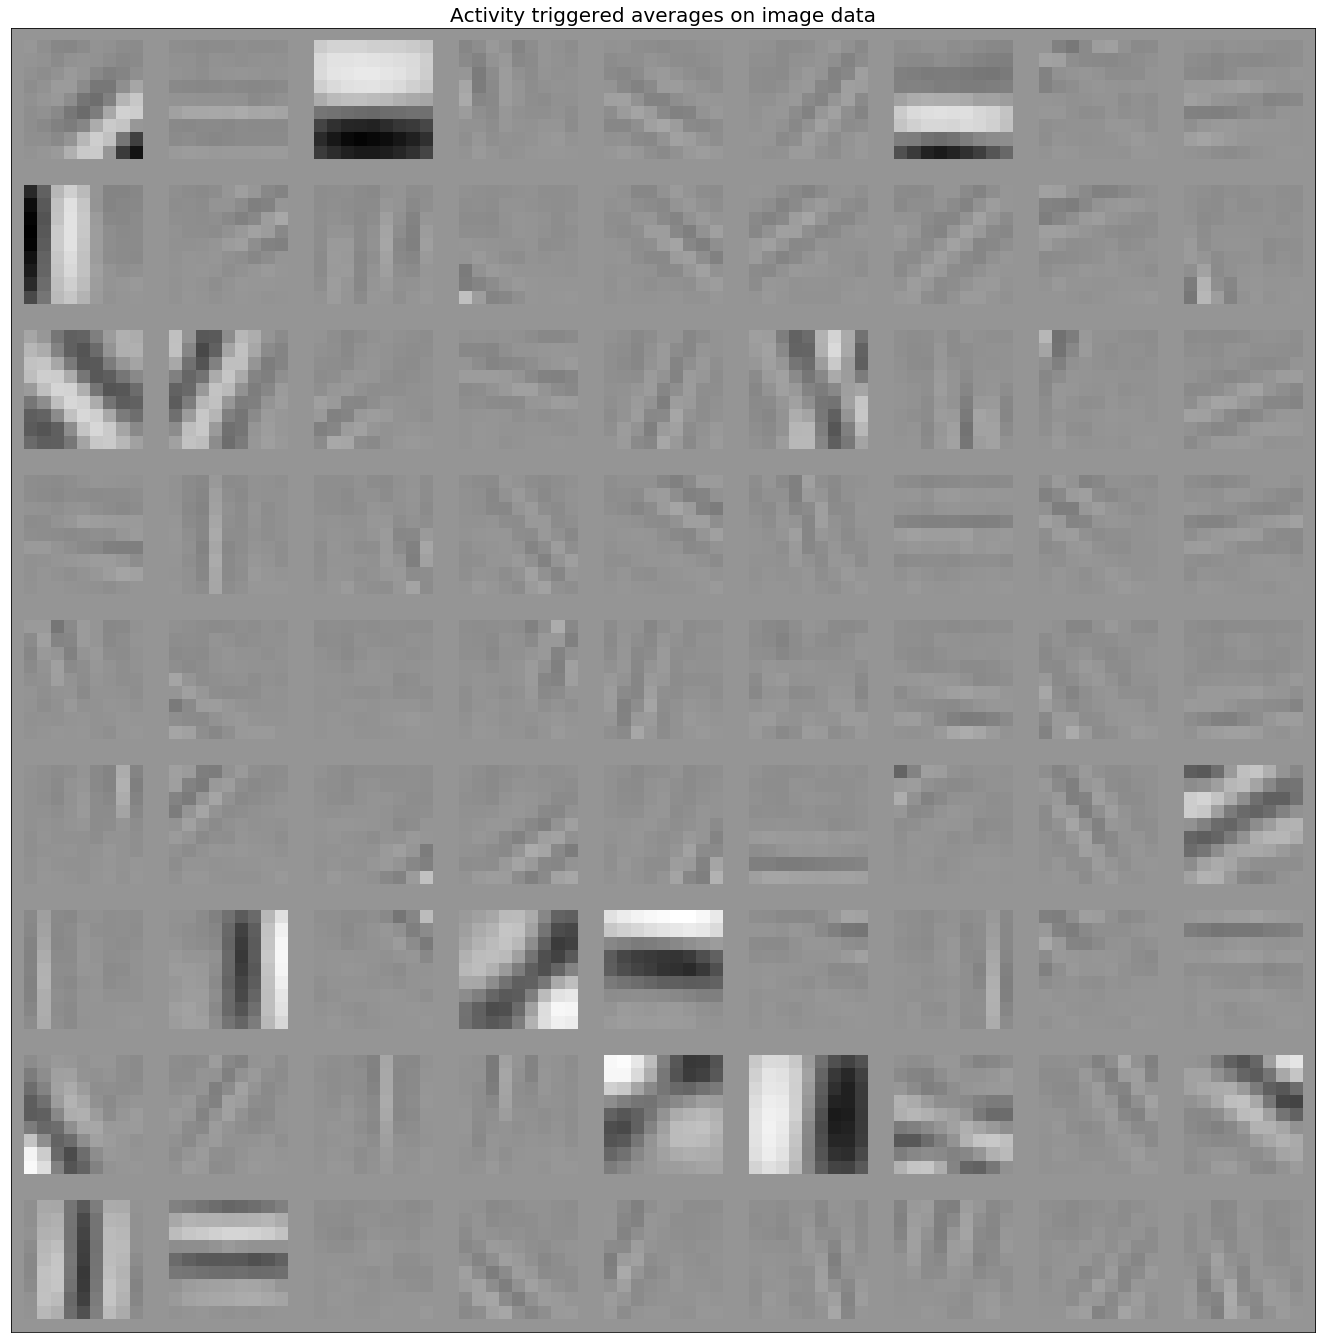

In [44]:
atas_fig = pf.plot_data_tiled(analyzer.atas.T, normalize=False, title="Activity triggered averages on image data")
atas_fig.savefig(analyzer.analysis_out_dir+analysis_params["model_name"]+"_img_atas.png")

In [7]:
#analyzer.cp_loc = "/home/dpaiton/Work/Projects/lca_vh_ft_1c/checkpoints/lca_vh_ft_1c_v0.0_full-100000"

INFO:tensorflow:Restoring parameters from /home/dpaiton/Work/Projects/lca_vh_ft_1c/checkpoints/lca_vh_ft_1c_v0.0_weights-100000


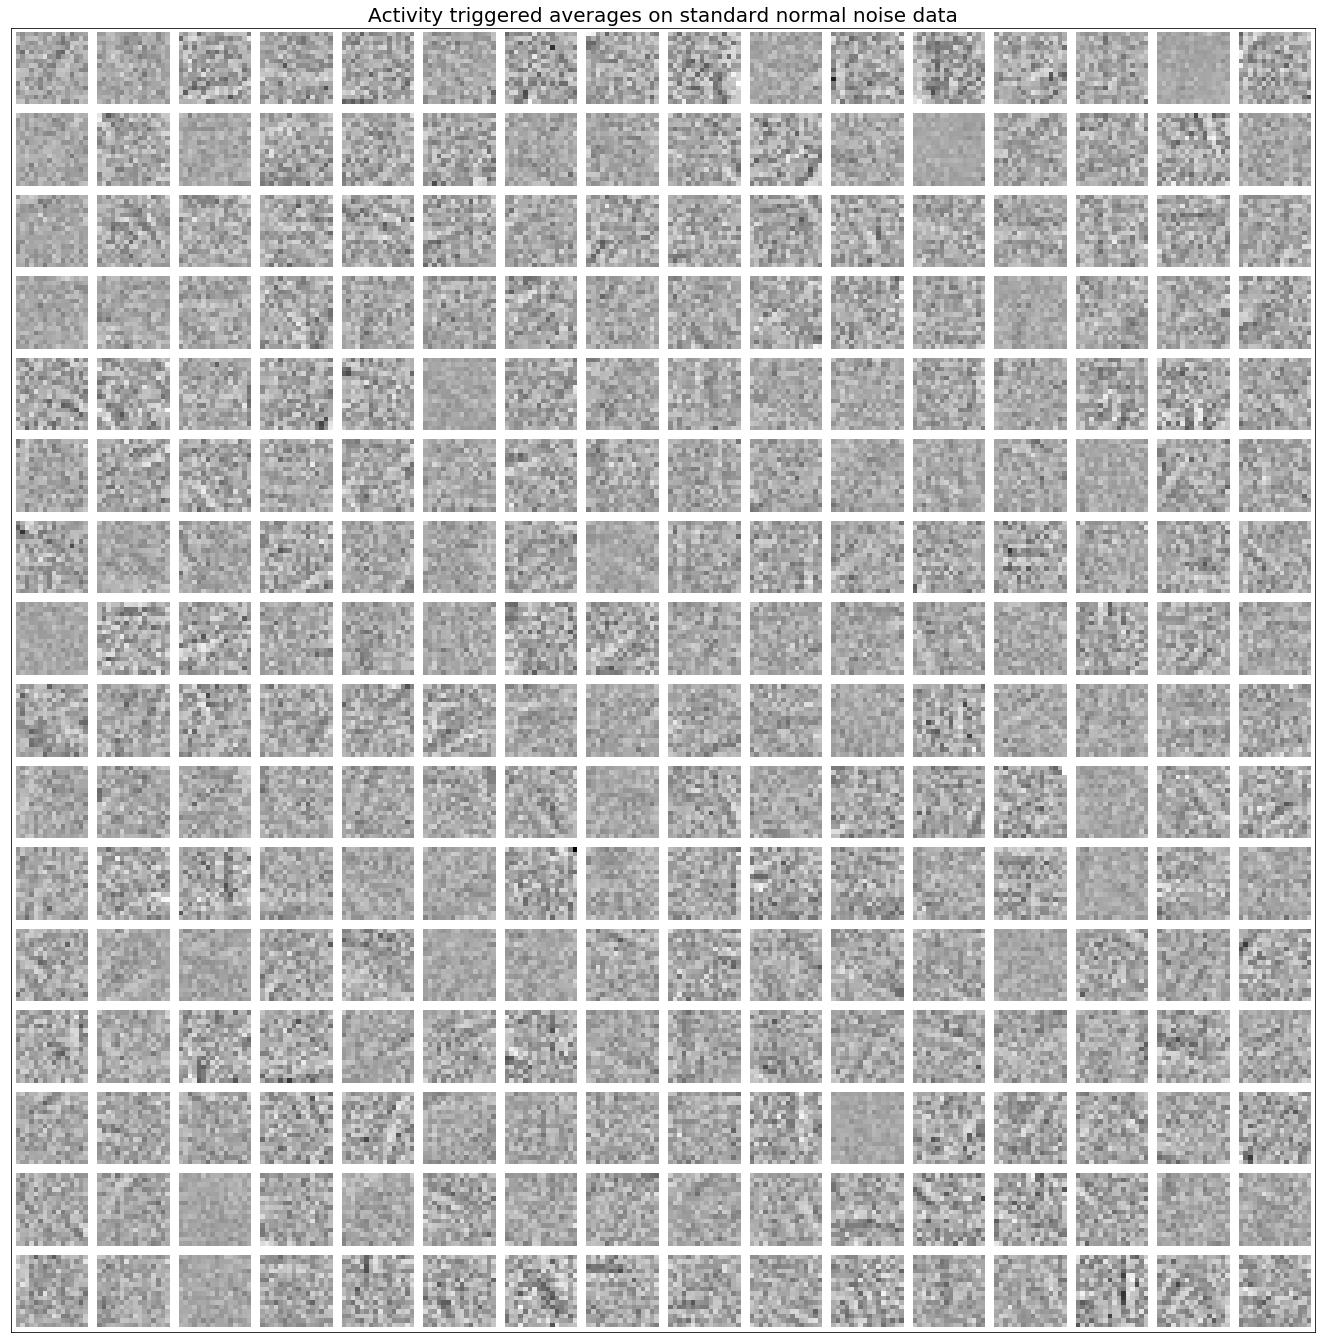

In [8]:
noise_images = np.random.standard_normal([analyzer.model_params["num_images"]]+analyzer.model_params["data_shape"])
noise_evals = analyzer.evaluate_model(noise_images, analyzer.var_names)
noise_atas = analyzer.compute_atas(noise_evals["inference/activity:0"], noise_images)
#noise_atas = analyzer.compute_atas(noise_evals["inference/coefficients:0"], noise_images)
noise_atas_fig = pf.plot_data_tiled(noise_atas.T, normalize=False, title="Activity triggered averages on standard normal noise data")
noise_atas_fig.savefig(analyzer.analysis_out_dir+analysis_params["model_name"]+"_noise_atas.png")

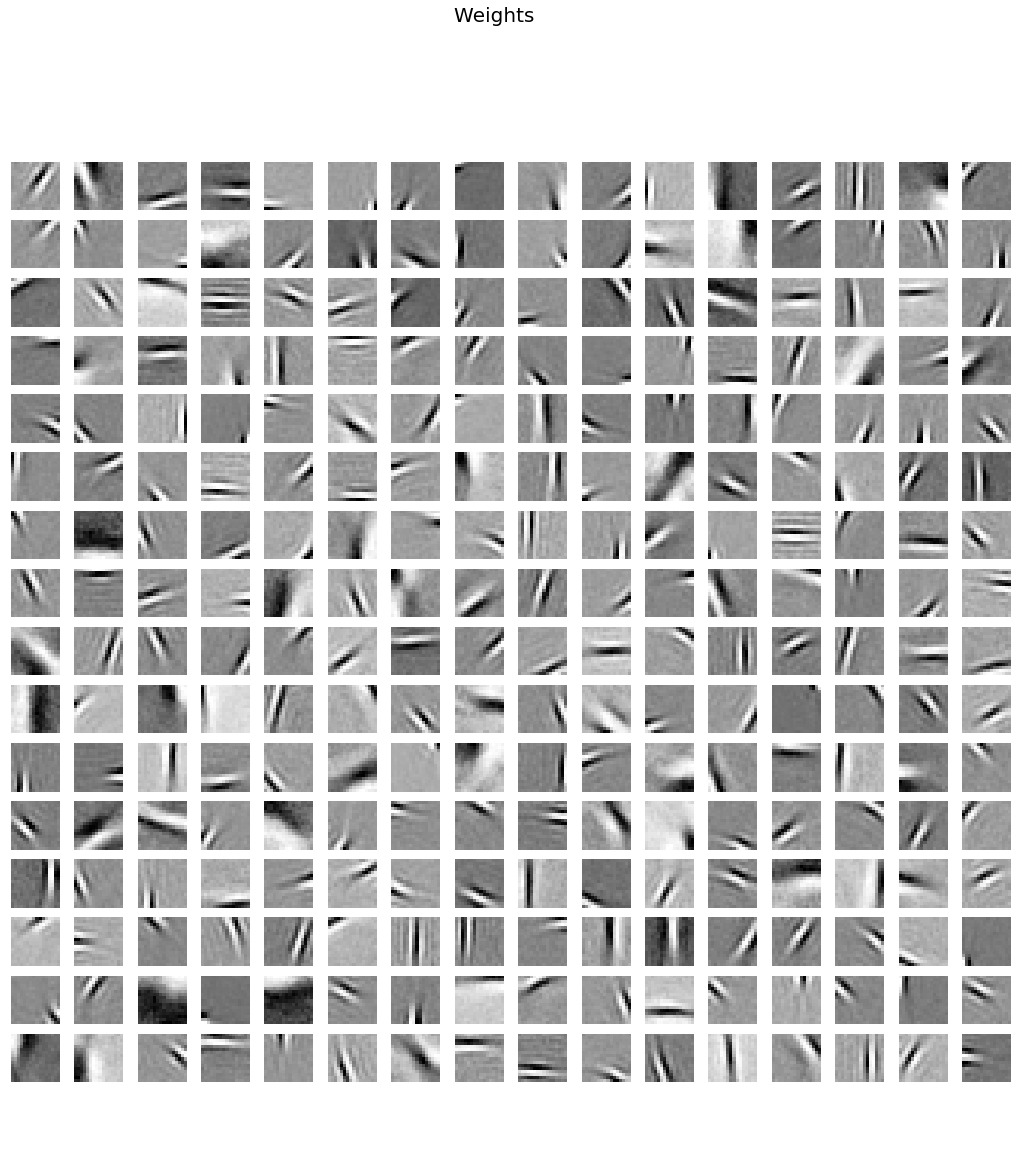

In [84]:
#dict_fig = pf.plot_data_tiled(analyzer.evals["weights/phi:0"].T, normalize=False, title="Weights")
weight_shape = [analyzer.bf_stats["num_outputs"], analyzer.bf_stats["patch_edge_size"], analyzer.bf_stats["patch_edge_size"]]
dict_fig = pf.plot_weights(analyzer.evals["weights/phi:0"].T.reshape(weight_shape), title="Weights")
#dict_fig = pf.plot_weights(analyzer.evals["weights/a_inverse:0"].T.reshape(weight_shape), title="Weights")
#dict_fig = pf.plot_weights(analyzer.evals["weights/w_enc:0"].T.reshape(weight_shape), title="Weights")
dict_fig.savefig(analyzer.analysis_out_dir+analysis_params["model_name"]+"_dict.png")

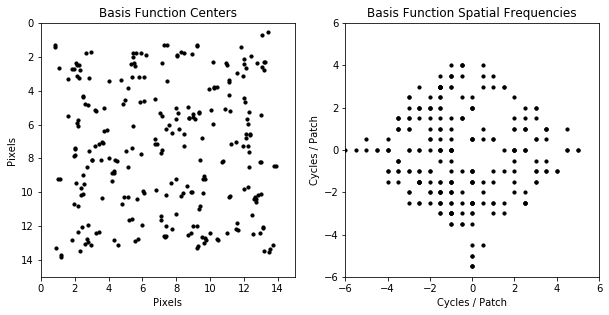

In [122]:
fig = pf.plot_loc_freq_summary(analyzer.bf_stats)
fig.savefig(analyzer.analysis_out_dir+"fig_location_frequency_centers.png")

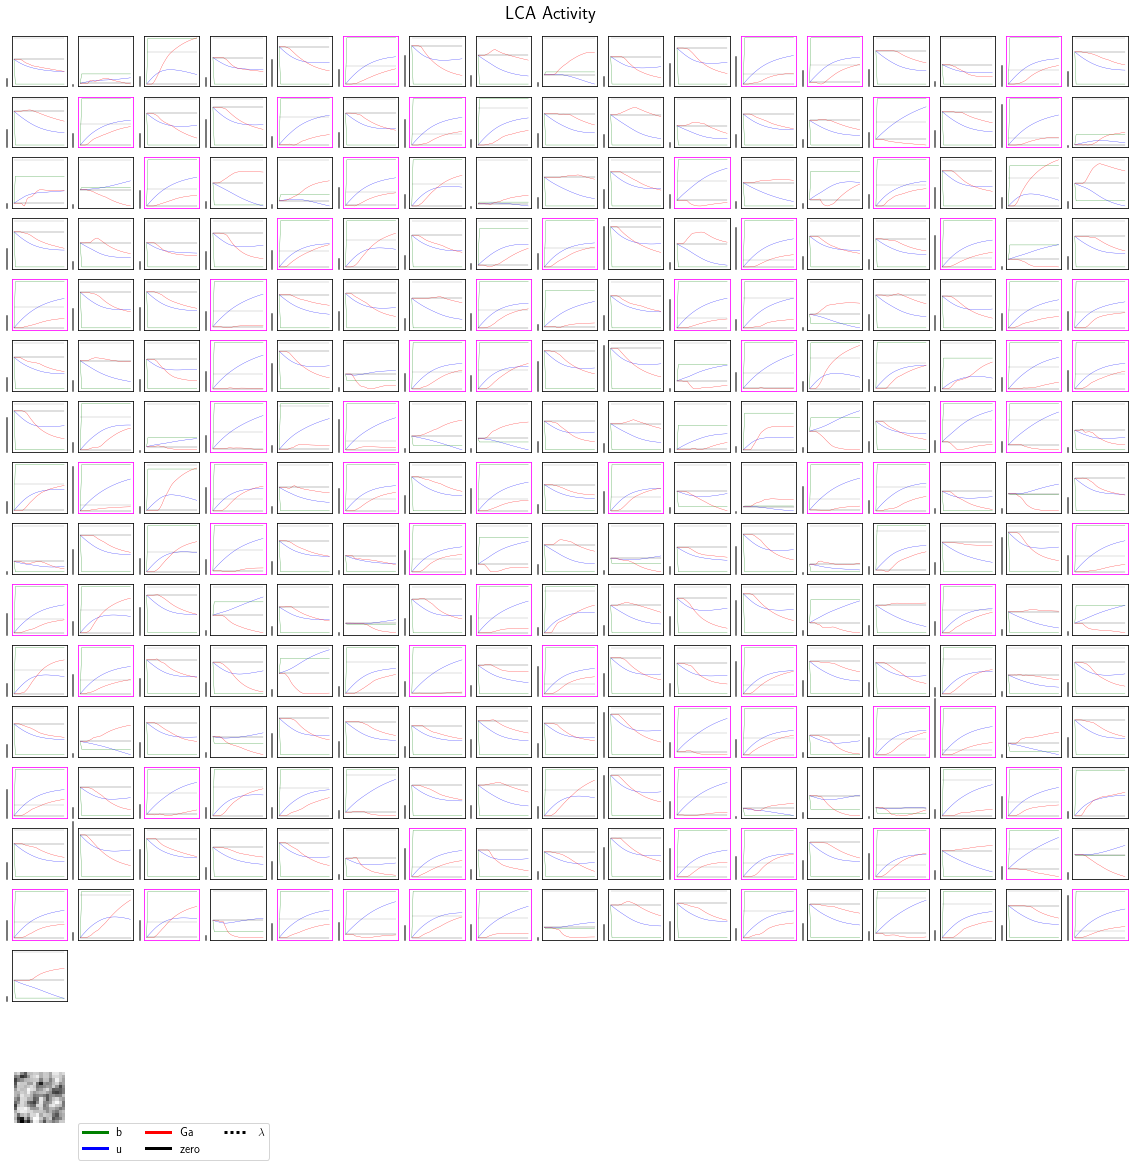

In [10]:
inf_trace_fig = pf.plot_inference_traces(analyzer.inference_stats, analyzer.model_schedule[0]["sparse_mult"])
inf_trace_fig.savefig(analyzer.analysis_out_dir+analysis_params["model_name"]+"_inference_traces.pdf")

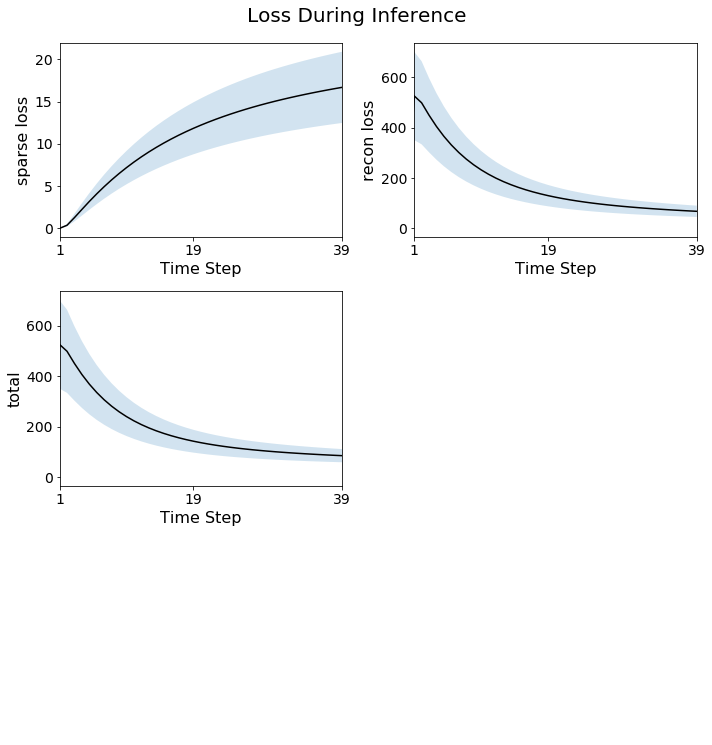

In [112]:
inf_stats_fig = pf.plot_inference_stats(analyzer.inference_stats, title="Loss During Inference")
inf_stats_fig.savefig(analyzer.analysis_out_dir+analysis_params["model_name"]+"_inference_loss.png")

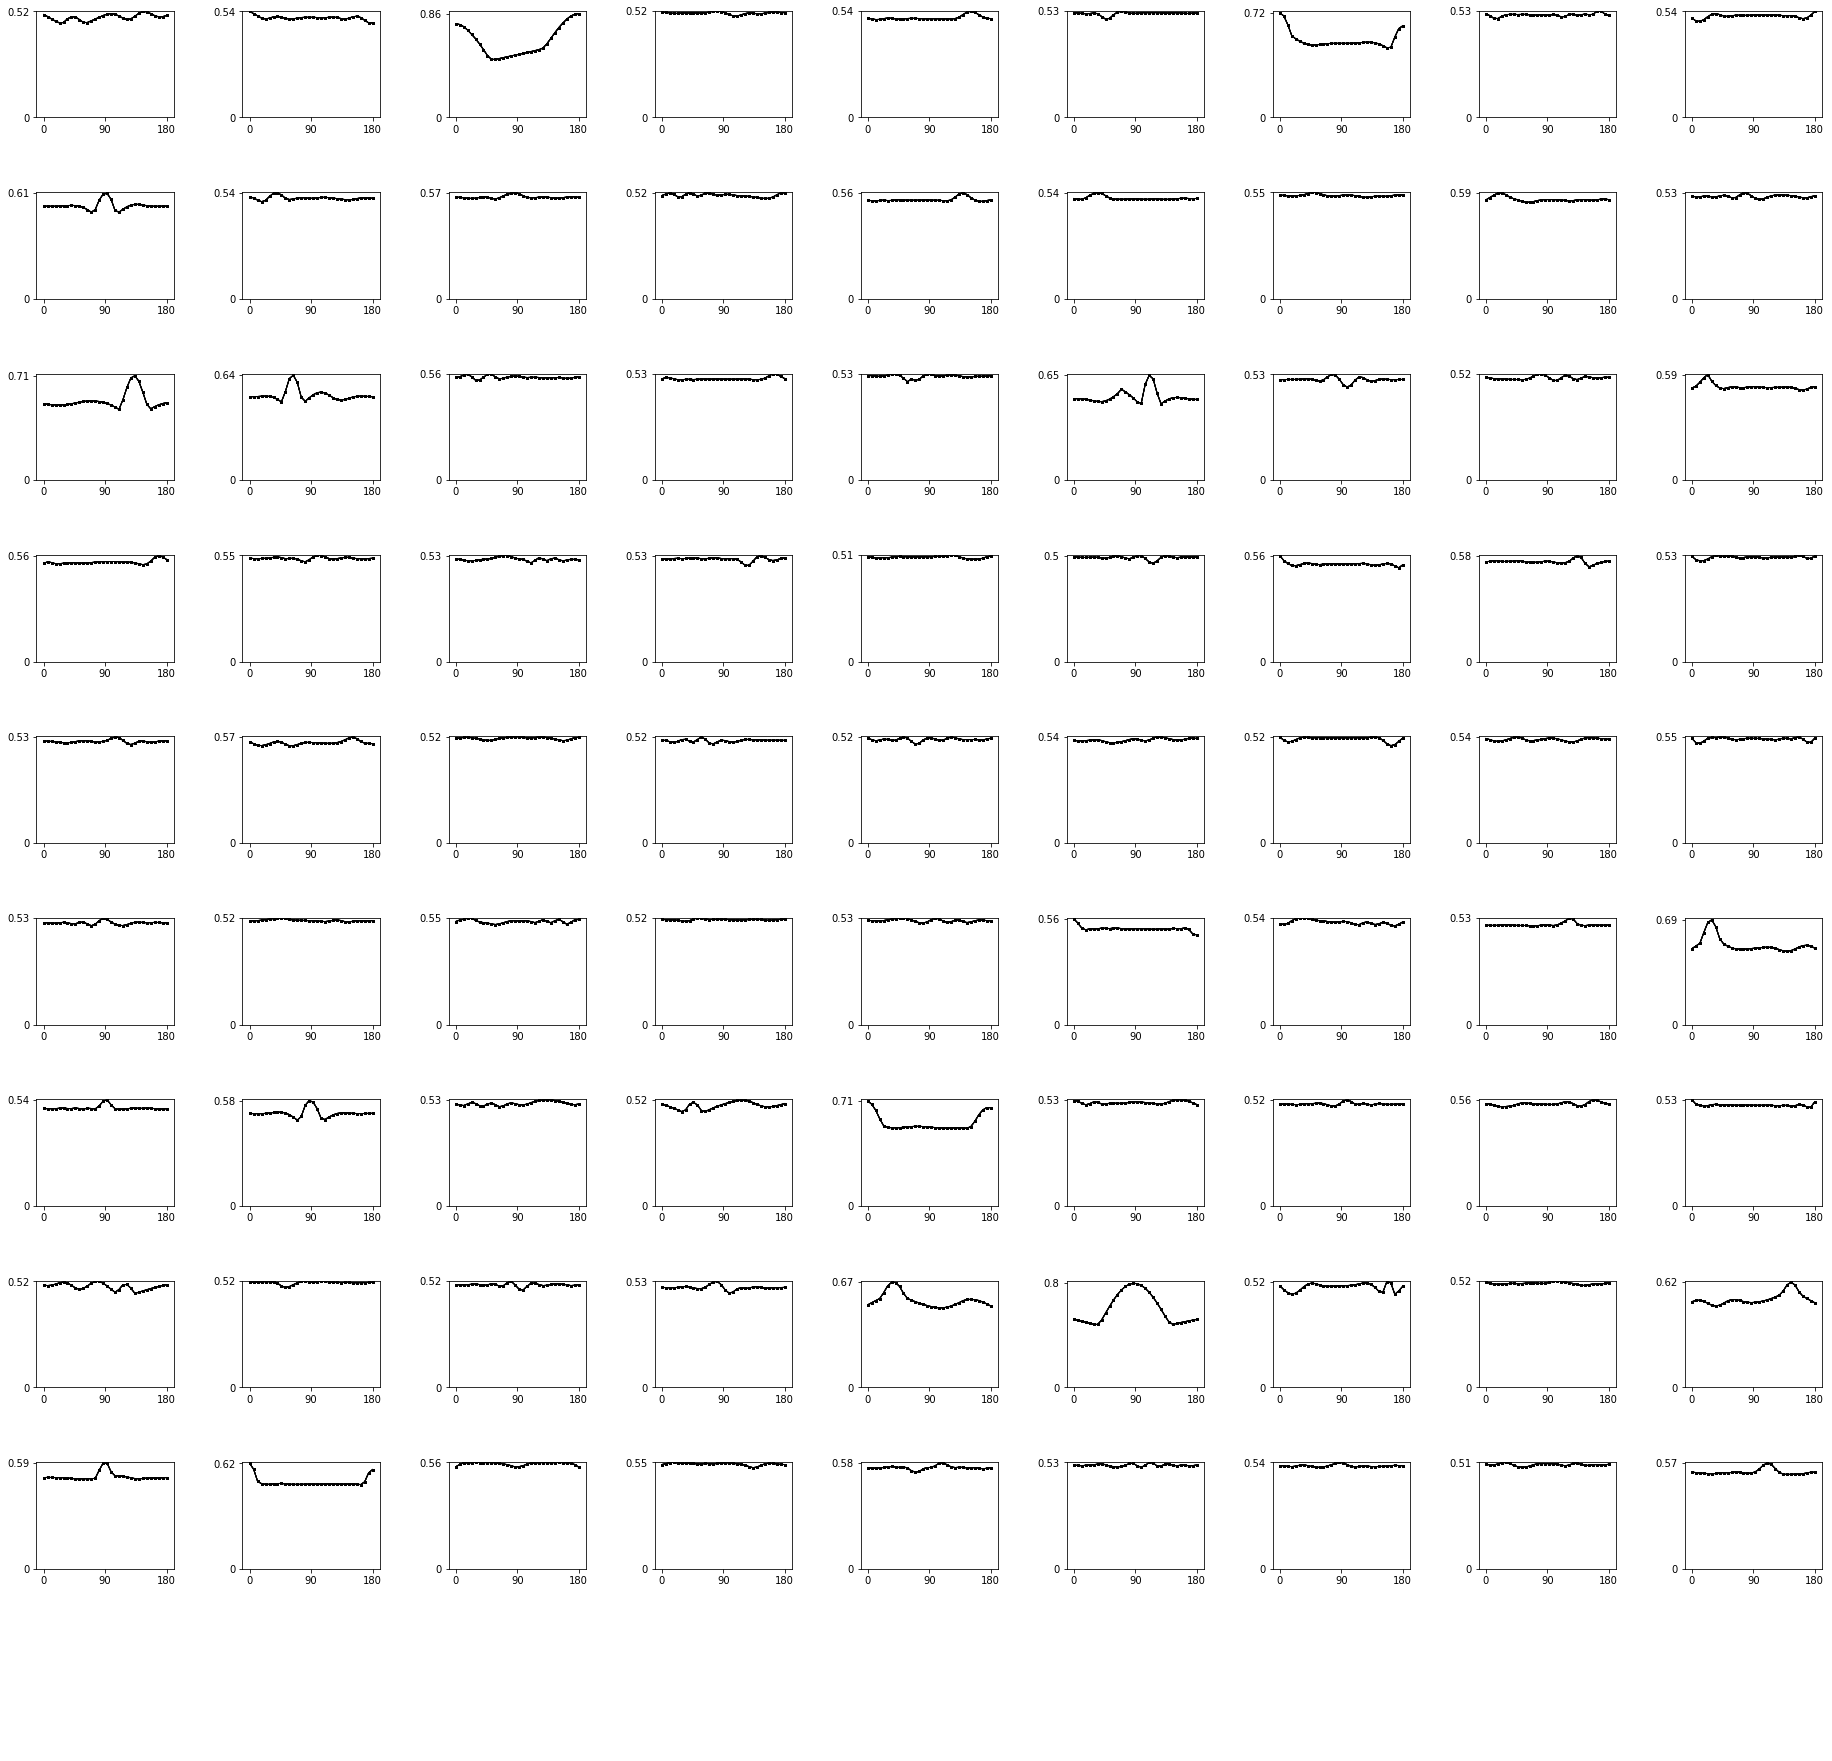

In [45]:
ot_fig = pf.plot_contrast_orientation_tuning(ot_bf_indices, ot_contrasts, ot_orientations, ot_mean_activations)
ot_fig.savefig(analyzer.analysis_out_dir+analysis_params["model_name"]+"_orientation_tuning.pdf")

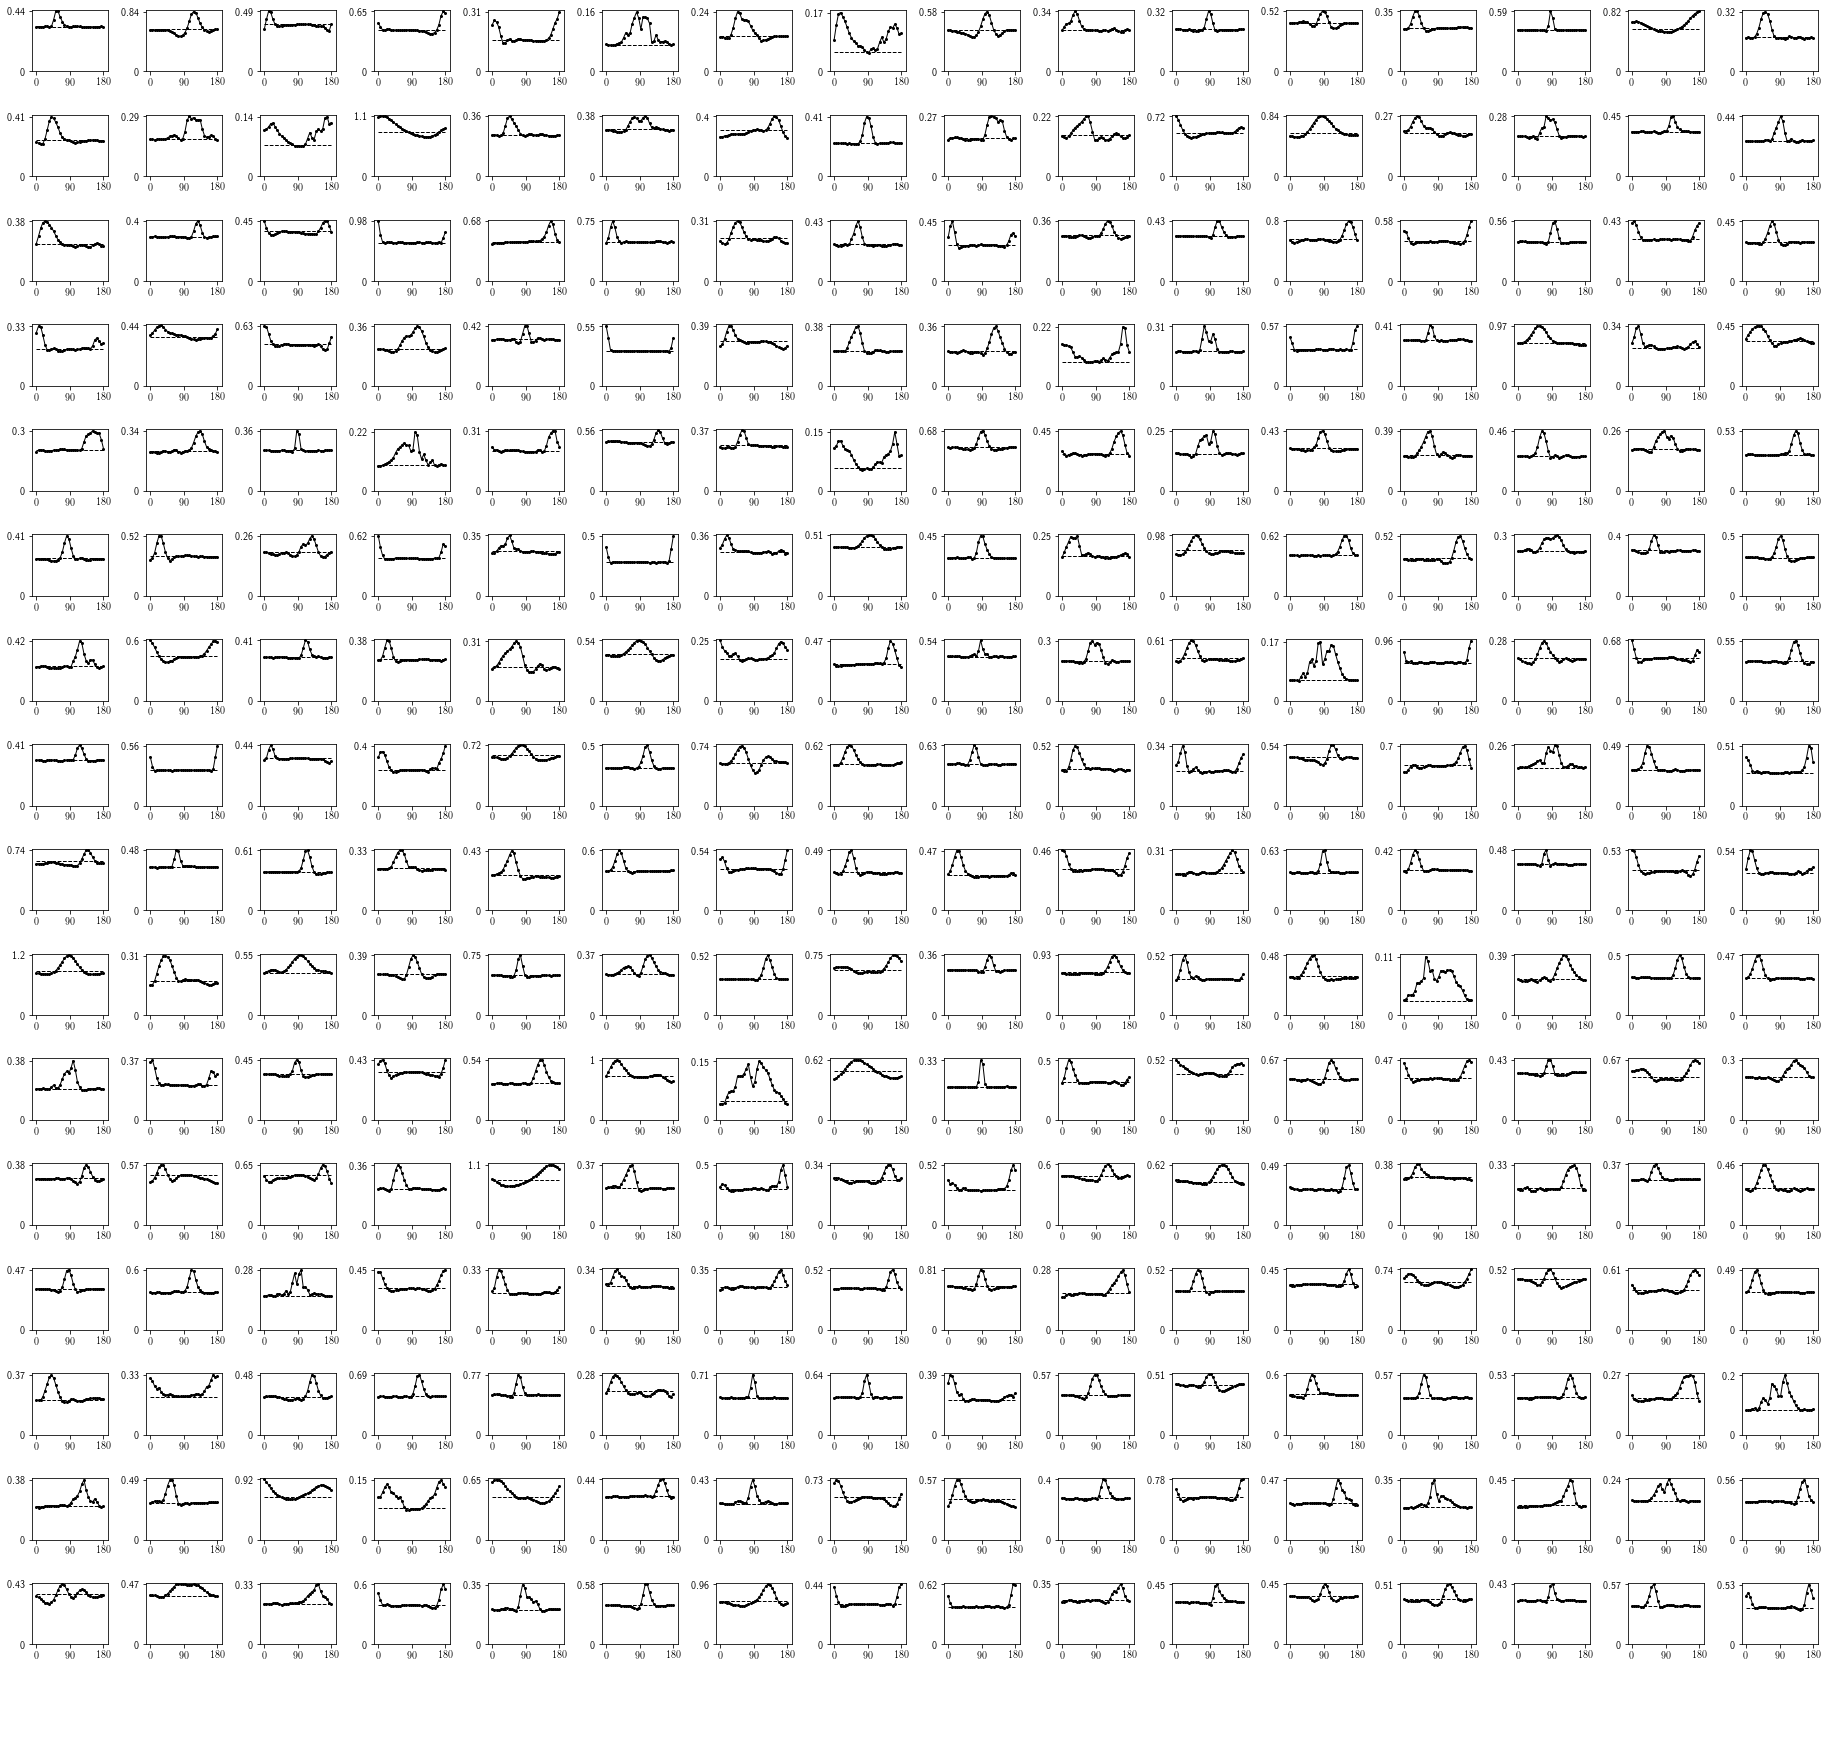

In [13]:
cross_fig = pf.plot_masked_orientation_tuning(co_bf_indices, co_mask_orientations, co_base_mean_responses, co_test_mean_responses)
cross_fig.savefig(analyzer.analysis_out_dir+analysis_params["model_name"]+"_cross_orientation_tuning.pdf")

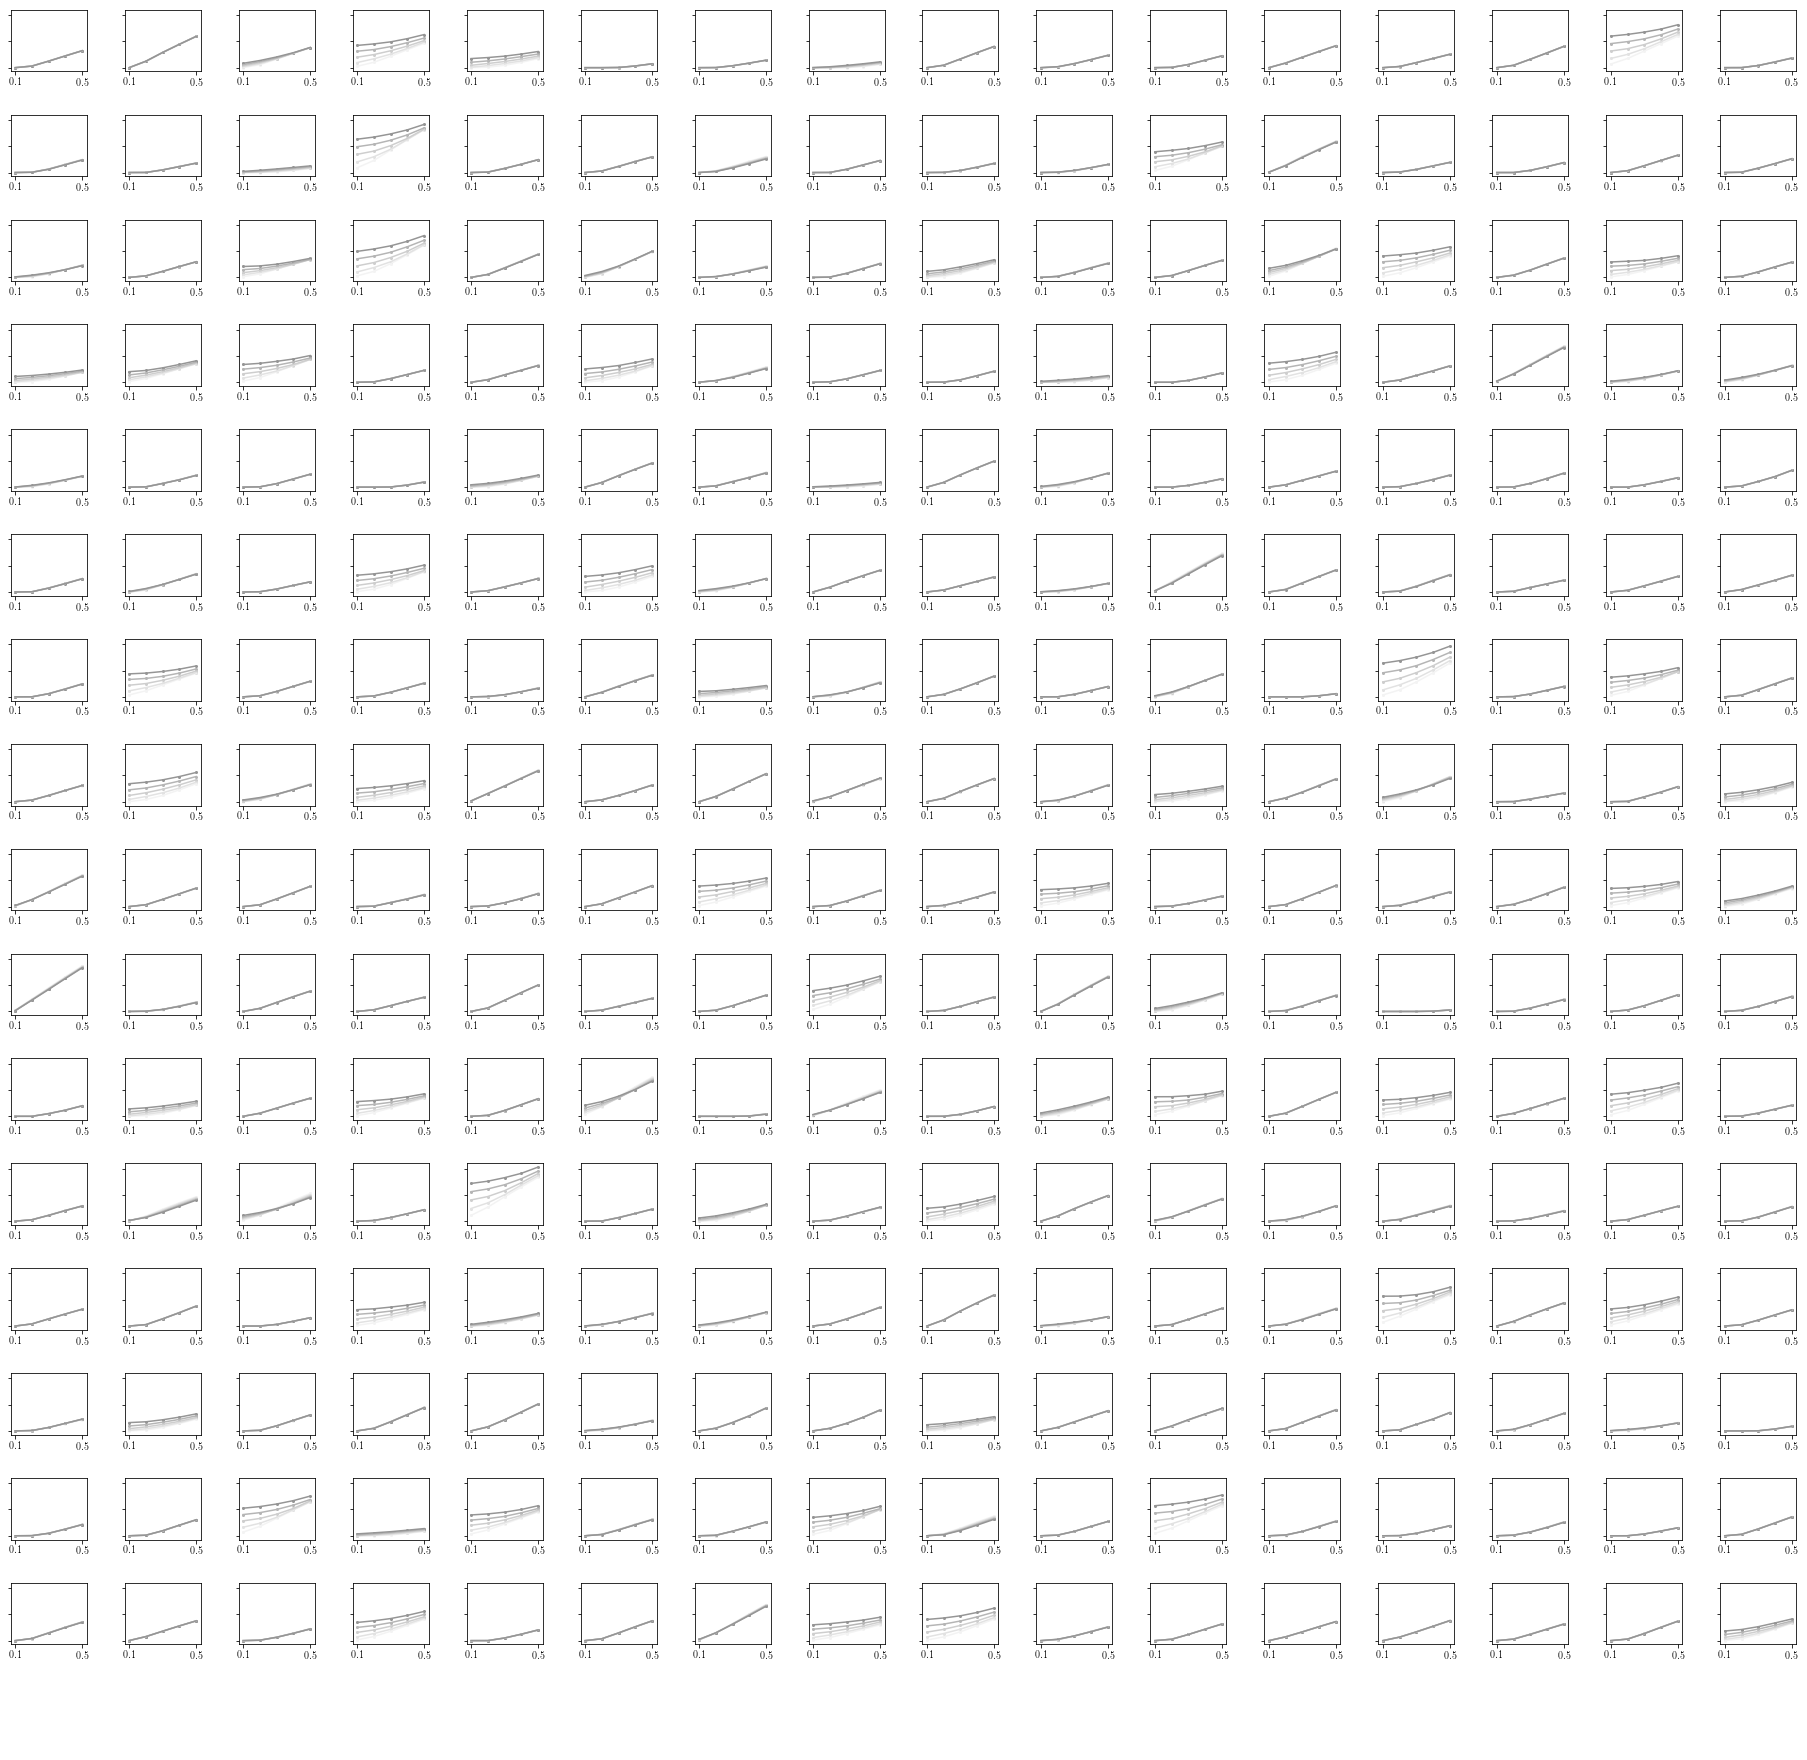

In [14]:
cross_contrast_fig = pf.plot_plaid_contrast_tuning(co_bf_indices, co_contrasts, co_contrasts, co_base_orientations,
  co_mask_orientations, co_test_mean_responses)
cross_contrast_fig.savefig(analyzer.analysis_out_dir+analysis_params["model_name"]+"_cross_contrast_orientation_tuning.pdf")

In [15]:
#grating = lambda bf_idx,orientation,phase,contrast:dp.generate_grating(
#  *dp.get_grating_params(bf_stats=analyzer.bf_stats, bf_idx=bf_idx, orientation=orientation,
#  phase=phase, contrast=contrast, diameter=-1)).reshape(16,16)
#
#bf_idx = 29
#bf = analyzer.evals["weights/phi:0"].T[co_bf_indices[bf_idx],:].reshape(16,16)
#base_stim = grating(co_bf_indices[bf_idx], co_base_orientations[bf_idx], co_phases[0], 0.5)
#mask_stim = grating(co_bf_indices[bf_idx], orthogonal_orientations[bf_idx], co_phases[5], 0.5)
#test_stim = base_stim + mask_stim
#
#all_min = np.min(np.stack([base_stim, mask_stim, test_stim]))
#all_max = np.max(np.stack([base_stim, mask_stim, test_stim]))
#
#fig, axes = plt.subplots(4)
#axes[0] = pf.clear_axis(axes[0])
#axes[1] = pf.clear_axis(axes[1])
#axes[2] = pf.clear_axis(axes[2])
#axes[3] = pf.clear_axis(axes[3])
#axes[0].imshow(bf, cmap="Greys_r")
#axes[1].imshow(base_stim, cmap="Greys_r", vmin=all_min, vmax=all_max)
#axes[2].imshow(mask_stim, cmap="Greys_r", vmin=all_min, vmax=all_max)
#axes[3].imshow(test_stim, cmap="Greys_r", vmin=all_min, vmax=all_max)
#plt.show()
#fig.savefig("/home/dpaiton/tmp_figs/"+analysis_params["model_name"]+"_ex_cross_stim.png")

In [16]:
#constructed_bfs = np.zeros_like(analyzer.evals["weights/phi:0"].T)
#for bf_idx in range(constructed_bfs.shape[0]):
#  params = dp.get_grating_params(analyzer.bf_stats, bf_idx)
#  grating = dp.generate_grating(*params)
#  constructed_bfs[bf_idx,...] = grating.reshape(256)
#fig = pf.plot_data_tiled(constructed_bfs)